In [ ]:
# Callin Switzer
# 16 July 2019
# python infrared reader

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import serial
import re
import csv
import seaborn as sns
import warnings
import sys
import os
from datetime import datetime
import glob
import time
import io

In [3]:
def is_mac():
    mac = True if sys.platform == "darwin" else False
    return(mac)
    
if not is_mac():
    import msvcrt
    import winsound

In [4]:
%matplotlib inline
print(sys.version)
print(sys.executable)

# define directories
baseDir = os.getcwd()

# data for storing datafile
dataDir = r"/Users/cswitzer/Desktop/MonarchSensor"
if not os.path.isdir(dataDir):
    os.mkdir(dataDir)

figDir = r"/Users/cswitzer/Desktop/MonarchFigs"
if not os.path.isdir(figDir):
    os.mkdir(figDir)

3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
/Users/cswitzer/anaconda3/envs/photogate/bin/python


In [5]:
def serial_ports():
    """ Lists serial port names
        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result

# list serial ports
serial_ports() # this arduino is on COM6

['/dev/tty.Bluetooth-Incoming-Port', '/dev/tty.usbmodem14101']

In [16]:
# connect to arduino
PORT1 = '/dev/tty.usbmodem14101'
connected1 = False
if "ser1" in globals():
    ser1.close()
    
#115200
ser1 = serial.Serial(PORT1, 115200, timeout=0.1) # stop if no data comes in 1 second
while not connected1:
    serin1 = ser1.readline()
    connected1 = True
    print("connected to arduino on " + PORT1)

time.sleep(3)
serin1 = ser1.readline()
print(serin1.decode("utf-8")) # should say "setup complete"

connected to arduino on /dev/tty.usbmodem14101
 Setup complete



In [17]:

fileStart = time.time()
print(fileStart)
fname = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(fileStart)) + "." + str(fileStart).split(".")[1]
fname

1567724080.755247


'2019-09-05 22:54:40.755247'

In [40]:
ctr = 0
ctr2 = 0
maxTime = 1 # minutes
previousTime = time.time_ns() / (10 ** 9)


while ctr2 < 1000:
        
    currentTime = time.time_ns() / (10 ** 9)
    
    if ctr == 0:
        
        minuteCounter = 0
        
        ser1.write("r".encode("utf-8"))
        txt = ser1.readline().decode("utf-8")
        
        if txt == "":
            print("restart")
            continue
        
        colNames = ["A" + str(i) for i, _ in enumerate(txt.split(','))]
        colNames.append("datetime")
        
        # make file  and write header
        fileStart = datetime.now()
        fname = (fileStart.strftime('%Y-%m-%d %H:%M:%S.%f'))
        fname = re.sub(r'[^\w\s]','_',fname)
        fname = re.sub(" ", "__", fname)[0:] + ".csv"

        with open(os.path.join(dataDir, fname), 'a+', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerows([colNames])
    
    if (currentTime - previousTime) >= 0.01:
        # read data
        ser1.write("r".encode("utf-8"))
        txt1 = ser1.readline().decode("utf-8")

        if txt1 != -1:
            txt = txt1.split(",")

            if ((len(txt) + 1) == len(colNames)):
                with open(os.path.join(dataDir, fname), 'a+', newline='') as myfile:
                    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                    txt.append(time.time_ns() / (10 ** 9))
                    wr.writerows([txt])
                    ctr2 += 1

        previousTime = currentTime
        ctr += 1
    


print('done')

done


In [41]:
# look at data
# read in data
dfile = os.path.join(dataDir,fname)
df1 = pd.read_csv(dfile)
#df1 = df1.iloc[1500:2000,:].copy()
#df1['datetime']= pd.to_datetime(df1['datetime'])
print(df1.shape)
df1.head()

(1000, 8)


,A0,A1,A2,A3,A4,A5,A6,datetime
0,310,225,221,220,306,344,7172,1.567724e+09
1,310,225,221,215,283,322,4144,1.567724e+09
2,310,225,221,241,322,345,10016,1.567724e+09
3,310,225,221,227,309,344,9972,1.567724e+09
4,310,225,221,223,290,318,10012,1.567724e+09


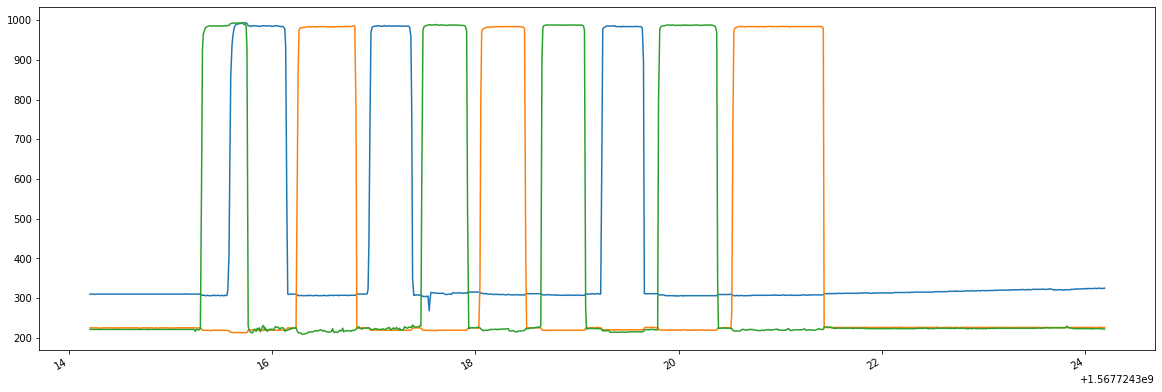

In [42]:
fig, ax = plt.subplots(1,1, figsize = [20,7])
for ii in range(3):
    ax.plot(df1.datetime, df1.iloc[:,ii])
fig.autofmt_xdate()
plt.show()

(9960, 10100)

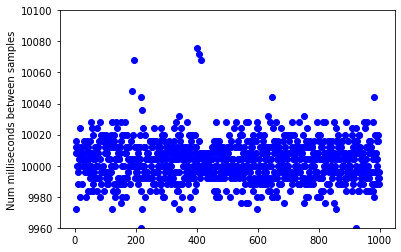

In [43]:
plt.plot(df1.A6, 'bo')
plt.ylabel("Num milliseconds between samples")
plt.ylim(9960, 10100)

Text(0.5, 0, 'sample num')

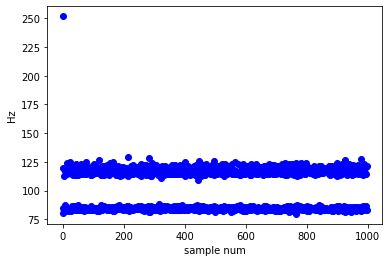

In [44]:
# calculate sampling rate
# we can speed this up if needed
# it's not super constant
timeDiff = np.diff(np.array(df1.datetime))
plt.plot(1/timeDiff, 'bo')
plt.ylabel("Hz")
plt.xlabel("sample num")

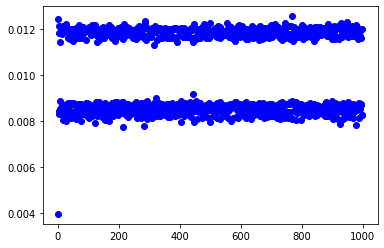

In [47]:
plt.plot(timeDiff, "bo")

In [ ]:
df1.head()

In [15]:
ser1.close()

1567722951.220906

In [ ]:
ctr = 0
maxTime = 6 # minutes


if not is_mac():
    while msvcrt.kbhit():
        msvcrt.getch()
        print('clearing characters ...')


while True:
    if not is_mac():
        if msvcrt.kbhit(): # if q, or escape is pressed, then break the loop
            k = msvcrt.getch()
            if(k == b'q') | (k == b'\x1b') | (k == b'\x0b') :
                print("keyboard break")
                winsound.MessageBeep()
                break
            

    if ctr == 0:
        
        minuteCounter = 0
       
        # tell arduino to write data to serial
        ser1.write("r".encode("utf-8"))
        # discard first read line, in case it's the wrong length
        ser1.readline()
        
        ser1.write("r".encode("utf-8"))
        txt = ser1.readline().decode("utf-8")
        colNames = ["A" + str(i) for i, _ in enumerate(txt.split(','))]
        colNames.append("datetime")
        
        # make file  and write header
        fileStart = datetime.now()
        fname = (fileStart.strftime('%Y-%m-%d %H:%M:%S.%f'))
        fname = re.sub(r'[^\w\s]','_',fname)
        fname = re.sub(" ", "__", fname)[0:] + ".csv"

        with open(os.path.join(dataDir, fname), 'a+', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerows([colNames])
    
    
    # read data
    ser1.write("r".encode("utf-8"))
    txt = ser1.readline().decode("utf-8")
    
    serData = [int(i) for i in txt.split(',') if i != ""]
    readTime = datetime.now()
    serData.append(readTime.strftime('%Y-%m-%d %H:%M:%S.%f'))

    # write data, but only if it's not an incorrect reading
    if (len(serData) != len(colNames)):
        print("data length is different from length of columns, dropping a reading")
        print(serData)
        print(colNames)
        continue
        
    elif (np.max(serData[:-1]) > 1023):
        print("data range incorrect, dropping a reading")
        continue
    
    else:
        with open(os.path.join(dataDir, fname), 'a+', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerows([serData])

    # print time
    c = readTime - fileStart
    if c.total_seconds()//60 == minuteCounter:
        print("Time elapsed (minutes):", minuteCounter)
        minuteCounter += 5 # print every 5 minutes
    
    if divmod(c.days * 86400 + c.seconds, 60)[0] >= maxTime:
        break   
    
    # update ctr
    ctr += 1
#     ser1.flushInput()

print('done')

In [ ]:
c.total_seconds()/60

In [ ]:
# look at data
# read in data
dfile = os.path.join(dataDir,fname)
df1 = pd.read_csv(dfile)
#df1 = df1.iloc[1500:2000,:].copy()
df1['datetime']= pd.to_datetime(df1['datetime'])
print(df1.shape)
df1.tail()

fig, ax = plt.subplots(1,1, figsize = [20,7])
for ii in range(3):
    ax.plot(df1.datetime, df1.iloc[:,ii])
fig.autofmt_xdate()
plt.show()


In [ ]:
fname

In [ ]:
# calculate sampling rate
# we can speed this up if needed
# it's not super constant
timeDiff = df1.datetime.diff() / np.timedelta64(1, 's')
plt.plot(1/timeDiff, 'bo')
plt.ylabel("Hz")
plt.xlabel("sample num")

In [ ]:
# calculate sampling rate
# we can speed this up if needed
# it's not super constant
timeDiff = df1.datetime.diff() / np.timedelta64(1, 's')
plt.plot(1/timeDiff[400:])
plt.ylabel("Hz")
plt.xlabel("sample num")

In [ ]:
#TESTING

In [ ]:
ctr = 0
maxTime = 6 # minutes

for ii in range(5000):
    if ctr == 0:
        
        minuteCounter = 0
       
        txt = ser1.readline().decode("utf-8")
        colNames = ["A" + str(i) for i, _ in enumerate(txt.split(','))]
        colNames.append("datetime")
        
        # make file  and write header
        fileStart = datetime.now()
        fname = (fileStart.strftime('%Y-%m-%d %H:%M:%S.%f'))
        fname = re.sub(r'[^\w\s]','_',fname)
        fname = re.sub(" ", "__", fname)[0:] + ".csv"

        with open(os.path.join(dataDir, fname), 'a+', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerows([colNames])
    
    
    # read data
    ser1.write("r".encode("utf-8"))
    txt = ser1.readline().decode("utf-8")


    with open(os.path.join(dataDir, fname), 'a+', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerows([(txt + "," + datetime.now().
                      strftime('%Y-%m-%d %H:%M:%S.%f')).rstrip().split(",")])

#     # print time
#     c = readTime - fileStart
#     if c.total_seconds()//60 == minuteCounter:
#         print("Time elapsed (minutes):", minuteCounter)
#         minuteCounter += 5 # print every 5 minutes
    
#     if divmod(c.days * 86400 + c.seconds, 60)[0] >= maxTime:
#         break   
    
    # update ctr
    ctr += 1


print('done')

In [5]:
int.from_bytes(b'\n', byteorder='big')

10

In [ ]:
readTime = datetime.now()
readTime.strftime('%Y-%m-%d %H:%M:%S.%f') + "," + txt

In [ ]:
with open(os.path.join(dataDir, fname), 'a+', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerows([(readTime.strftime('%Y-%m-%d %H:%M:%S.%f') + "," + txt).split(",")])

In [ ]:
[(txt + "," + datetime.now().
  strftime('%Y-%m-%d %H:%M:%S.%f')).rstrip().split(",")]